In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

train = pd.read_csv('../data/train/train.csv')

In [2]:
submission = pd.read_csv('../data/sample_submission.csv')
submission.set_index('id',inplace=True)

In [3]:
import warnings
warnings.filterwarnings(action='ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
def eval_dewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [27]:
train['GHI'] = train['DNI']*math.cos(math.pi/180*63)+train['DHI']
train['DP'] = 0
for i in range(len(train)):
    train.loc[i, ["DP"]] = eval_dewpoint(float(train.loc[i, ["T"]]), train.loc[i , ["RH"]])

In [4]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,DP
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,-16.522271
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,-16.525742
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,-16.061776
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,-16.066807
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,-15.500215


In [5]:
train['GHI'].describe()

count    52560.000000
mean       170.937627
std        213.324929
min          0.000000
25%          0.000000
50%          0.000000
75%        387.580939
max        700.964276
Name: GHI, dtype: float64

In [6]:
train['DHI'].describe()

count    52560.000000
mean        64.344121
std        103.897125
min          0.000000
25%          0.000000
50%          0.000000
75%         87.000000
max        528.000000
Name: DHI, dtype: float64

In [7]:
train['DNI'].describe()

count    52560.000000
mean       234.792371
std        349.684583
min          0.000000
25%          0.000000
50%          0.000000
75%        469.000000
max       1059.000000
Name: DNI, dtype: float64

In [4]:
def transform(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels
x_col =['DHI','DNI','WS', 'RH', 'T', 'TARGET']
# x_col = ['DHI','DNI','WS', 'RH', 'T', 'TARGET','GHI']
# x_col = ['WS', 'RH', 'T', 'TARGET','GHI']
y_col = ['TARGET']
dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

past_history = 48 * 2
future_target = 48 * 2

### transform train
train_data, train_label = transform(dataset, label, 0, None, past_history,future_target, 1)
### transform test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'../data/test/{i}.csv')
#     tmp['GHI'] = tmp['DNI']*math.cos(math.pi/180*63)+tmp['DHI']
#     tmp['DP'] = 0
#     for i in range(len(tmp)):
#         tmp.loc[i, ["DP"]] = eval_dewpoint(float(tmp.loc[i, ["T"]]), tmp.loc[i , ["RH"]])    
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

In [5]:
train_data = np.nan_to_num(train_data)

In [30]:
print(train_data.shape)
print(train_label.shape)

(1091, 480)
(1091, 96)


### Random Forest Parameter Optimizing

In [85]:
features

[0.6691818272771449,
 0.6890615413217206,
 0.7004972463495638,
 0.707692721433148,
 0.7120438618371683,
 0.715960825244966,
 0.7189192837008181,
 0.7207231950387429,
 0.7220890206170419,
 0.7229891419818241,
 0.7239946955502438,
 0.7250181805257444,
 0.7253332964438061,
 0.7265301256891133,
 0.7261817547085624,
 0.7266527947501155,
 0.7262733183654806,
 0.7279808766114518,
 0.7279018753815544,
 0.728226020464081]

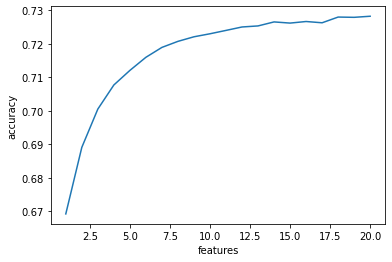

[0.6691818272771449, 0.6890615413217206, 0.7004972463495638, 0.707692721433148, 0.7120438618371683, 0.715960825244966, 0.7189192837008181, 0.7207231950387429, 0.7220890206170419, 0.7229891419818241, 0.7239946955502438, 0.7250181805257444, 0.7253332964438061, 0.7265301256891133, 0.7261817547085624, 0.7266527947501155, 0.7262733183654806, 0.7279808766114518, 0.7279018753815544, 0.728226020464081]


In [84]:
x = np.arange(1,21)
plt.xlabel("features")
plt.ylabel("accuracy")
plt.plot(x,features)
plt.show()
print(features)

In [34]:
# feature testing = 20
from sklearn.ensemble import RandomForestRegressor
features = []
N_ESTIMATORS = 500
for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=i, random_state=0,
                                    max_depth = 5,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    features.append(rf.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s 

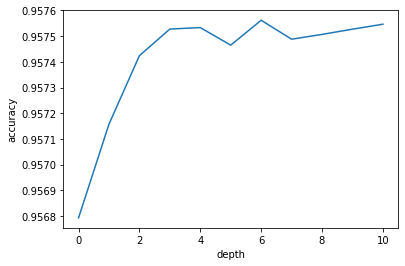

In [88]:
x = np.arange(0,11)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.plot(x,depth)
plt.show()

In [87]:
for i in range(0,11):
    print(i, depth[i])

0 0.9567920685426307
1 0.9571572861216616
2 0.9574240178792529
3 0.9575276680956785
4 0.9575334289258608
5 0.9574649720523931
6 0.9575620260677192
7 0.9574881510912315
8 0.9575069125451449
9 0.9575272102779712
10 0.9575466506615208


In [33]:
# max_depth test = 20
depth = []
N_ESTIMATORS = 1000
for i in range(20,31):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=10, random_state=0,
                                    max_depth = i,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    print(rf.score(train_data, train_label))
    depth.append(rf.score(train_data, train_label))

NameError: name 'RandomForestRegressor' is not defined

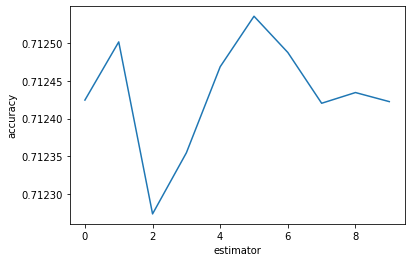

In [91]:
x = np.arange(10)
plt.xlabel("estimator")
plt.ylabel("accuracy")
plt.plot(x,estimator)
plt.show()

In [90]:
estimator

[0.7124246311201884,
 0.7125017622099351,
 0.7122736848090243,
 0.7123547130961869,
 0.7124688315001083,
 0.7125357840528074,
 0.7124877421266979,
 0.7124204024952213,
 0.7124346120342805,
 0.712422584167197]

In [89]:
# estimator test = 1500
estimator = []
# N_ESTIMATORS = 1000
for i in range(1000,2000,100):
    rf = ensemble.RandomForestRegressor(n_estimators=i,
                                    max_features=5, random_state=0,
                                    max_depth = 5,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    print(rf.score(train_data, train_label))
    estimator.append(rf.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


0.7124246311201884


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.5s finished
[Paralle

0.7125017622099351


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[Paralle

0.7122736848090243


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=

0.7123547130961869


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1300 out of 1300 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs

0.7124688315001083


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1400 out of 1400 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs

0.7125357840528074


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs

0.7124877421266979


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1700 out of 1700 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs

0.7124204024952213


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1700 out of 1700 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jo

0.7124346120342805


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1900 out of 1900 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_j

0.712422584167197


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1900 out of 1900 | elapsed:    0.6s finished


### Apply Grid Search

In [31]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [1500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 4)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [1500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_data, train_label)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)
# Model Performance
# Average Error: 3.9199 degrees.
# Accuracy = 93.36%.
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)
# Model Performance
# Average Error: 3.7152 degrees.
# Accuracy = 93.73%.
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
# Improvement of 0.40%.

### Modeling

In [13]:
train_label.reshape(1, -1).shape

(1, 104736)

In [22]:
# random forest real modeling
from sklearn.ensemble import RandomForestRegressor
N_ESTIMATORS = 3000
features = 100
depth = 100

rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=features, random_state=0,
                                    max_depth = depth,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)
print("Clear")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.4min finished


RandomForestRegressor(max_depth=100, max_features=100, n_estimators=3000,
                      n_jobs=-1, random_state=0, verbose=True)

Clear


In [21]:
train_data.shape
train_label.shape

(1091, 576)

(1091, 96)

In [23]:
rf_preds = []
for estimator in rf.estimators_:
#     print(estimator.predict(test).dtype)
    result = estimator.predict(test).astype(np.float64)
    rf_preds.append(result)
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    
    submission.iloc[:, i] = np.ravel(y_pred)

In [24]:
submission.to_csv(f'이모티콘가져와.csv')

In [20]:
from sklearn.ensemble import ExtraTreesRegressor
N_ESTIMATORS = 1500
features = 50
depth = 50

ETR_model = ExtraTreesRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=features, random_state=0,
                                    max_depth = depth,
                                    verbose=True,
                                    n_jobs=-1)
ETR_model.fit(train_data, train_label)
print("Clear")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.8s finished


ExtraTreesRegressor(max_depth=10, max_features=10, n_estimators=1500, n_jobs=-1,
                    random_state=0, verbose=True)

Clear


In [58]:
ETR_pred = []
for estimator in ETR_model.estimators_:
#     print(estimator.predict(test).dtype)
    result = estimator.predict(test).astype(np.float64)
    ETR_pred.append(result)
ETR_pred = np.array(ETR_pred)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(ETR_pred, q * 100, axis=0)
    
    submission.iloc[:, i] = np.ravel(y_pred)